# Short sentiment snippets (the Pang/Lee Rotten Tomatoes dataset)
Dataset Informations: https://nlp.stanford.edu/wiki/Software/Classifier/Sentiment

Dowload the data from http://www.cs.cornell.edu/People/pabo/movie-review-data/rt-polaritydata.tar.gz to the folder:
```
melime/experiments/data/ 
```
unzip the data. You can use something as:
```
tar -xzf rt-polaritydata.tar.gz
```

In [1]:
import sys, os
sys.path.append('..')

import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from melime.generators.word2vec_gen import Word2VecGen
from melime.explainers.explainer import Explainer
from melime.explainers.visualizations.plot_importance import ExplainGraph
from melime.explainers.visualizations.visualization import ExplainText

### Load dataset

In [2]:
path_ = './data/rt-polaritydata/'
def load_polarity(path=path_):
    data = []
    labels = []
    f_names = ['rt-polarity.neg', 'rt-polarity.pos']
    for (l, f) in enumerate(f_names):
        for line in open(os.path.join(path, f), 'rb'):
            data.append(line.decode('utf8', errors='ignore').strip())
            labels.append(l)
    return data, labels

In [3]:
x, y = load_polarity()
x_train_all, x_test, y_train_all, y_test = train_test_split(
    x, y, test_size=.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_all, y_train_all, test_size=.1, random_state=42)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

### Vectorize Text

In [4]:
class VectorizeText():
        def __init__(self):
            self.count_vect = CountVectorizer()
            self.tf_transformer = TfidfTransformer(use_idf=False)
        def fit(self, x):
            x = self.count_vect.fit_transform(x)
            self.tf_transformer.fit(x)
        def transform(self, x):
            x = self.count_vect.transform(x)
            x = self.tf_transformer.transform(x)
            return x     

### ML model - MultinomialNB from sklearn

In [5]:
vect_text = VectorizeText()
vect_text.fit(x_train)    
x_vec_train = vect_text.transform(x_train)

# Train Model
clf = MultinomialNB().fit(x_vec_train, y_train)

def MNB_predict(texts):
    return clf.predict(vect_text.transform(texts))
def MNB_predict_prob(texts):
    return clf.predict_proba(vect_text.transform(texts))

preds = MNB_predict(x_val)
print('Val accuracy', metrics.accuracy_score(y_val, preds))


Val accuracy 0.7584994138335287


### MeLIME using Word2VecGen

In [6]:
generator = Word2VecGen(x_train_all)

Instance to be explained

In [7]:
x_explain = [x_test[1]]
print('x_explain:', x_explain)
print(x_explain[0])
print('Predicted class:', MNB_predict(x_explain)[0])
print('Predict probabilities:', MNB_predict_prob(x_explain))
print('True class:', y_test[1])

x_explain: ["the movie's thesis -- elegant technology for the masses -- is surprisingly refreshing ."]
the movie's thesis -- elegant technology for the masses -- is surprisingly refreshing .
Predicted class: 1
Predict probabilities: [[0.29029215 0.70970785]]
True class: 1


In [8]:
x_explain = np.array(x_explain)

### Generating Explanation

In [9]:
feature_names=[f'{e}: {word}' for e, word in enumerate(x_explain[0].split())]
words=[f'{word}' for e, word in enumerate(x_explain[0].split())]
explainer = Explainer(
    model_predict=MNB_predict_prob, feature_names=feature_names, generator=generator
)
explanation, con_fav_samples = explainer.explain_instance(
    x_explain=x_explain,
    class_index=1,
    n_samples=50,
    tol_importance=0.001,
    include_x_explain_train=False,    
)

(1, 14)


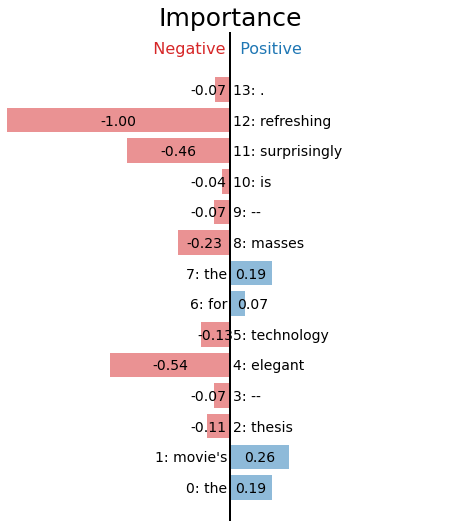

In [10]:
explain_dict = explanation.explain()
fig, ax = plt.subplots(figsize=(8, 9))
ax.set_title('Importance', fontsize=25)
names = feature_names
importances = [*explain_dict['importances']['mean'].values()]
ax = ExplainGraph.plot_feature_importance(
ax=ax, names=feature_names, vals=importances, size_title=15)
plt.savefig('text_explanation.pdf', dpi=300)

Favorable sampled phrases:

In [11]:
for phrase, prob in zip(con_fav_samples.samples_fav, con_fav_samples.y_fav):
    print(f'{phrase} - Prop {prob:5.3f}')

the movie's thesis -- elegant technology for touching masses -- is surprisingly refreshing . - Prop 0.823
touching movie's thesis -- elegant technology for the masses -- is surprisingly refreshing . - Prop 0.823
the touching thesis -- elegant technology for the masses -- is surprisingly refreshing . - Prop 0.821
the movie's thesis -- elegant technology for wonderful masses -- is surprisingly refreshing . - Prop 0.820
wonderful movie's thesis -- elegant technology for the masses -- is surprisingly refreshing . - Prop 0.820


Contrary sampled phrases:

In [12]:
for phrase, prob in zip(con_fav_samples.samples_con, con_fav_samples.y_con):
    print(f'{phrase} - Prob.: {prob:5.3}')

the movie's thesis -- elegant technology for the masses -- is surprisingly heavy-handed . - Prob.: 0.468
the movie's thesis -- elegant technology for the masses -- is surprisingly dull . - Prob.:  0.47
the movie's thesis -- elegant technology for the masses -- is surprisingly pretentious . - Prob.: 0.491
the movie's thesis -- elegant technology for the masses -- is surprisingly unfunny . - Prob.: 0.492
the movie's thesis -- elegant technology for the masses -- is surprisingly mess . - Prob.: 0.494


In [13]:
obj = ExplainText.plot(importances=importances, words=words)
obj

In [14]:
with open("explain_text.html", "w") as fd:
    fd.write(obj.data)

Thank you!